# Latent Dirichlet Allocation

The purpose of applying the LDA method is to obtain the distribution of words that make up a topic and documents with a particular topic. The first stage in LDA modeling is to initialize the parameters. These parameters can be the number of documents, the number of words in the document, the number of topics, the number of iterations, and the LDA coefficient. The next stage is to mark a word with a predetermined topic by applying a semi-random distribution based on the Dirichlet distribution method. Next is the iteration stage. In this stage, there are parameters that can determine the distribution of the number of topics and the distribution of words from topics in a document.

## Dependencies

In [ ]:
!pip install google-cloud-bigquery
!pip install PySastrawi
!pip install nltk
!pip install pyLDAvis

In [ ]:
import pandas as pd
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
from string import punctuation
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim
from gensim.models.coherencemodel import CoherenceModel
import re
import pyLDAvis.gensim_models
import pickle
import numpy as np, pandas as pd

## Load Data

In [ ]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'future-data-track-1-sapporo.json'

In [ ]:
# Imports the Google Cloud client library
from google.cloud import bigquery

In [ ]:
# Instantiates a client for Bigquery Service
bigquery_client = bigquery.Client(project='future-data-track-1')

In [ ]:
# Query for BigQuery
QUERY = """
SELECT
  *
FROM
  `future-data-track-1.sapporo_staging.app_review`
LIMIT
  100
"""

In [ ]:
# Run the query and get data from BigQuery
query_job = bigquery_client.query(QUERY) # API request

In [ ]:
# Ture the data into pandas DataFrame
df = query_job.to_dataframe()

In [ ]:
# Show the result
df

,app_name,app_id,review_id,user_name,review,rating,app_version,created_date,platform,dag_execution_date,user_image,thumbs_up_count,reply,replied_at
0,bhinneka,bmd.android.apps,gp:AOqpTOGGWa6RFQpFCoh4rvkYSOGjzi_U5kjTaB_u7R4...,anis ridwan,"Woi balikin saldo saya 100k, trx gagal..",1,None,2020-10-15 13:15:47+00:00,Play Store,2021-12-17 13:36:00+00:00,https://play-lh.googleusercontent.com/a/AATXAJ...,2,None,NaT
1,bhinneka,bmd.android.apps,gp:AOqpTOHHowKgsa6Qrcsd4Vg4KhP4HQmxgJONLJPMSPk...,Anita,"Bayar pajak, kan aneh ya barang lokal",1,None,2020-08-18 13:45:18+00:00,Play Store,2021-12-17 13:36:00+00:00,https://play-lh.googleusercontent.com/a-/AOh14...,2,None,NaT
2,bhinneka,bmd.android.apps,gp:AOqpTOGw3IUB_EN1S98wBnKhZfUAPeugd85p33CzEg2...,Karya Muda Kaliasin KMK,"Sampah, isi alamat aja kaga muncul centang",1,None,2021-01-14 13:23:44+00:00,Play Store,2021-12-17 13:36:00+00:00,https://play-lh.googleusercontent.com/a-/AOh14...,5,None,NaT
3,bhinneka,bmd.android.apps,gp:AOqpTOEo5_rUfHashBdRLL-LaPcnUONdO_1SayFs6Hz...,Pengguna Google,parahhhhh,1,None,2019-01-31 11:26:23+00:00,Play Store,2021-12-17 13:36:00+00:00,https://play-lh.googleusercontent.com/EGemoI2N...,1,Mohon agar dapat menginformasikan kendala yang...,2019-02-27 07:28:38+00:00
4,bhinneka,bmd.android.apps,gp:AOqpTOH4t9180LrWw-MWpWNNvzd1JLXjAdllj-CZHVW...,Laila Ramadhani,Nyebelin banget d cari apa yang keluar apa tru...,1,None,2018-03-23 02:46:18+00:00,Play Store,2021-12-17 13:36:00+00:00,https://play-lh.googleusercontent.com/a/AATXAJ...,2,Mohon maaf atas ketidaknyamanannya. Terkait ke...,2018-04-04 04:13:57+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,bhinneka,bmd.android.apps,gp:AOqpTOGzFWfXFX4cnBFzxA4Rxzld8fO80cR0xX6tEct...,Pengguna Google,Mau beli tapi stok pada habis..,1,1.0.0.2010-production,2018-02-27 16:49:15+00:00,Play Store,2021-12-17 13:36:00+00:00,https://play-lh.googleusercontent.com/EGemoI2N...,1,None,NaT
96,bhinneka,bmd.android.apps,gp:AOqpTOFFpM07R6ep_tHAjxShBAL_f6X4JT00zTjXQ3l...,Pengguna Google,Saya daftar selalu tidak bisa tulisannya tidak...,1,1.0.0.2010-production,2018-01-24 03:01:41+00:00,Play Store,2021-12-17 13:36:00+00:00,https://play-lh.googleusercontent.com/EGemoI2N...,14,None,NaT
97,bhinneka,bmd.android.apps,gp:AOqpTOEi2jjdSTgV_QXDUMCG9aKFPIl81liesnTEvSB...,All Evy,"Aplikasi hidup segan mati tak mau,lebih baik d...",1,1.0.0.2010-production,2018-03-11 10:34:10+00:00,Play Store,2021-12-17 13:36:00+00:00,https://play-lh.googleusercontent.com/a-/AOh14...,2,None,NaT
98,bhinneka,bmd.android.apps,gp:AOqpTOFGmrv-bFg7XzurBmr2vMNESBpfv31-ak9sLKj...,Aldy Gallagher,"Udah 3 hari barang ga sampe sampe, padahal mas...",1,1.0.0.2010-production,2018-02-15 01:01:20+00:00,Play Store,2021-12-17 13:36:00+00:00,https://play-lh.googleusercontent.com/a-/AOh14...,3,None,NaT


In [ ]:
# Select columns

df_preprocess = df[['review', 'rating']]
df_preprocess

,review,rating
0,"Woi balikin saldo saya 100k, trx gagal..",1
1,"Bayar pajak, kan aneh ya barang lokal",1
2,"Sampah, isi alamat aja kaga muncul centang",1
3,parahhhhh,1
4,Nyebelin banget d cari apa yang keluar apa tru...,1
...,...,...
95,Mau beli tapi stok pada habis..,1
96,Saya daftar selalu tidak bisa tulisannya tidak...,1
97,"Aplikasi hidup segan mati tak mau,lebih baik d...",1
98,"Udah 3 hari barang ga sampe sampe, padahal mas...",1


## Preprocess

### Initial Stopwords

In [ ]:
# Extending Sastrawi StopWords

class ExtendStopWordRemoverFactory(StopWordRemoverFactory):
  def get_stop_word(self):
    new_sw = ["ada","adalah","adanya","adapun","agak","agaknya","agar","akan","akankah","akhir","akhiri","akhirnya","aku","akulah","amat","amatlah","anda","andalah","antar","antara","antaranya","apa","apaan","apabila","apakah","apalagi","apatah","artinya","asal","asalkan","atas","atau","ataukah","ataupun","awal","awalnya","bagai","bagaikan","bagaimana","bagaimanakah","bagaimanapun","bagi","bagian","bahkan","bahwa","bahwasanya","baik","bakal","bakalan","balik","banyak","bapak","baru","bawah","beberapa","begini","beginian","beginikah","beginilah","begitu","begitukah","begitulah","begitupun","bekerja","belakang","belakangan","belum","belumlah","benar","benarkah","benarlah","berada","berakhir","berakhirlah","berakhirnya","berapa","berapakah","berapalah","berapapun","berarti","berawal","berbagai","berdatangan","beri","berikan","berikut","berikutnya","berjumlah","berkali-kali","berkata","berkehendak","berkeinginan","berkenaan","berlainan","berlalu","berlangsung","berlebihan","bermacam","bermacam-macam","bermaksud","bermula","bersama","bersama-sama","bersiap","bersiap-siap","bertanya","bertanya-tanya","berturut","berturut-turut","bertutur","berujar","berupa","besar","betul","betulkah","biasa","biasanya","bila","bilakah","bisa","bisakah","boleh","bolehkah","bolehlah","buat","bukan","bukankah","bukanlah","bukannya","bulan","bung","cara","caranya","cukup","cukupkah","cukuplah","cuma","dahulu","dalam","dan","dapat","dari","daripada","datang","dekat","demi","demikian","demikianlah","dengan","depan","di","dia","diakhiri","diakhirinya","dialah","diantara","diantaranya","diberi","diberikan","diberikannya","dibuat","dibuatnya","didapat","didatangkan","digunakan","diibaratkan","diibaratkannya","diingat","diingatkan","diinginkan","dijawab","dijelaskan","dijelaskannya","dikarenakan","dikatakan","dikatakannya","dikerjakan","diketahui","diketahuinya","dikira","dilakukan","dilalui","dilihat","dimaksud","dimaksudkan","dimaksudkannya","dimaksudnya","diminta","dimintai","dimisalkan","dimulai","dimulailah","dimulainya","dimungkinkan","dini","dipastikan","diperbuat","diperbuatnya","dipergunakan","diperkirakan","diperlihatkan","diperlukan","diperlukannya","dipersoalkan","dipertanyakan","dipunyai","diri","dirinya","disampaikan","disebut","disebutkan","disebutkannya","disini","disinilah","ditambahkan","ditandaskan","ditanya","ditanyai","ditanyakan","ditegaskan","ditujukan","ditunjuk","ditunjuki","ditunjukkan","ditunjukkannya","ditunjuknya","dituturkan","dituturkannya","diucapkan","diucapkannya","diungkapkan","dong","dua","dulu","empat","enggak","enggaknya","entah","entahlah","guna","gunakan","hal","hampir","hanya","hanyalah","hari","harus","haruslah","harusnya","hendak","hendaklah","hendaknya","hingga","ia","ialah","ibarat","ibaratkan","ibaratnya","ibu","ikut","ingat","ingat-ingat","ingin","inginkah","inginkan","ini","inikah","inilah","itu","itukah","itulah","jadi","jadilah","jadinya","jangan","jangankan","janganlah","jauh","jawab","jawaban","jawabnya","jelas","jelaskan","jelaslah","jelasnya","jika","jikalau","juga","jumlah","jumlahnya","justru","kala","kalau","kalaulah","kalaupun","kalian","kami","kamilah","kamu","kamulah","kan","kapan","kapankah","kapanpun","karena","karenanya","kasus","kata","katakan","katakanlah","katanya","ke","keadaan","kebetulan","kecil","kedua","keduanya","keinginan","kelamaan","kelihatan","kelihatannya","kelima","keluar","kembali","kemudian","kemungkinan","kemungkinannya","kenapa","kepada","kepadanya","kesampaian","keseluruhan","keseluruhannya","keterlaluan","ketika","khususnya","kini","kinilah","kira","kira-kira","kiranya","kita","kitalah","kok","kurang","lagi","lagian","lah","lain","lainnya","lalu","lama","lamanya","lanjut","lanjutnya","lebih","lewat","lima","luar","macam","maka","makanya","makin","malah","malahan","mampu","mampukah","mana","manakala","manalagi","masa","masalah","masalahnya","masih","masihkah","masing","masing-masing","mau","maupun","melainkan","melakukan","melalui","melihat","melihatnya","memang","memastikan","memberi","memberikan","membuat","memerlukan","memihak","meminta","memintakan","memisalkan","memperbuat","mempergunakan","memperkirakan","memperlihatkan","mempersiapkan","mempersoalkan","mempertanyakan","mempunyai","memulai","memungkinkan","menaiki","menambahkan","menandaskan","menanti","menanti-nanti","menantikan","menanya","menanyai","menanyakan","mendapat","mendapatkan","mendatang","mendatangi","mendatangkan","menegaskan","mengakhiri","mengapa","mengatakan","mengatakannya","mengenai","mengerjakan","mengetahui","menggunakan","menghendaki","mengibaratkan","mengibaratkannya","mengingat","mengingatkan","menginginkan","mengira","mengucapkan","mengucapkannya","mengungkapkan","menjadi","menjawab","menjelaskan","menuju","menunjuk","menunjuki","menunjukkan","menunjuknya","menurut","menuturkan","menyampaikan","menyangkut","menyatakan","menyebutkan","menyeluruh","menyiapkan","merasa","mereka","merekalah","merupakan","meski","meskipun","meyakini","meyakinkan","minta","mirip","misal","misalkan","misalnya","mula","mulai","mulailah","mulanya","mungkin","mungkinkah","nah","naik","namun","nanti","nantinya","nyaris","nyatanya","oleh","olehnya","pada","padahal","padanya","pak","paling","panjang","pantas","para","pasti","pastilah","penting","pentingnya","per","percuma","perlu","perlukah","perlunya","pernah","persoalan","pertama","pertama-tama","pertanyaan","pertanyakan","pihak","pihaknya","pukul","pula","pun","punya","rasa","rasanya","rata","rupanya","saat","saatnya","saja","sajalah","saling","sama","sama-sama","sambil","sampai","sampai-sampai","sampaikan","sana","sangat","sangatlah","satu","saya","sayalah","se","sebab","sebabnya","sebagai","sebagaimana","sebagainya","sebagian","sebaik","sebaik-baiknya","sebaiknya","sebaliknya","sebanyak","sebegini","sebegitu","sebelum","sebelumnya","sebenarnya","seberapa","sebesar","sebetulnya","sebisanya","sebuah","sebut","sebutlah","sebutnya","secara","secukupnya","sedang","sedangkan","sedemikian","sedikit","sedikitnya","seenaknya","segala","segalanya","segera","seharusnya","sehingga","seingat","sejak","sejauh","sejenak","sejumlah","sekadar","sekadarnya","sekali","sekali-kali","sekalian","sekaligus","sekalipun","sekarang","sekarang","sekecil","seketika","sekiranya","sekitar","sekitarnya","sekurang-kurangnya","sekurangnya","sela","selain","selaku","selalu","selama","selama-lamanya","selamanya","selanjutnya","seluruh","seluruhnya","semacam","semakin","semampu","semampunya","semasa","semasih","semata","semata-mata","semaunya","sementara","semisal","semisalnya","sempat","semua","semuanya","semula","sendiri","sendirian","sendirinya","seolah","seolah-olah","seorang","sepanjang","sepantasnya","sepantasnyalah","seperlunya","seperti","sepertinya","sepihak","sering","seringnya","serta","serupa","sesaat","sesama","sesampai","sesegera","sesekali","seseorang","sesuatu","sesuatunya","sesudah","sesudahnya","setelah","setempat","setengah","seterusnya","setiap","setiba","setibanya","setidak-tidaknya","setidaknya","setinggi","seusai","sewaktu","siap","siapa","siapakah","siapapun","sini","sinilah","soal","soalnya","suatu","sudah","sudahkah","sudahlah","supaya","tadi","tadinya","tahu","tahun","tak","tambah","tambahnya","tampak","tampaknya","tandas","tandasnya","tanpa","tanya","tanyakan","tanyanya","tapi","tegas","tegasnya","telah","tempat","tengah","tentang","tentu","tentulah","tentunya","tepat","terakhir","terasa","terbanyak","terdahulu","terdapat","terdiri","terhadap","terhadapnya","teringat","teringat-ingat","terjadi","terjadilah","terjadinya","terkira","terlalu","terlebih","terlihat","termasuk","ternyata","tersampaikan","tersebut","tersebutlah","tertentu","tertuju","terus","terutama","tetap","tetapi","tiap","tiba","tiba-tiba","tidak","tidakkah","tidaklah","tiga","tinggi","toh","tunjuk","turut","tutur","tuturnya","ucap","ucapnya","ujar","ujarnya","umum","umumnya","ungkap","ungkapnya","untuk","usah","usai","waduh","wah","wahai","waktu","waktunya","walau","walaupun","wong","yaitu","yakin","yakni","yang"]
    new_sw.extend(super().get_stop_words())
    return list(set(new_sw))

In [ ]:
sw_remover = ExtendStopWordRemoverFactory().create_stop_word_remover()

In [ ]:
random_state = 0

### Initial Token

In [ ]:
# list for tokenized documents in loop
texts = []

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')

### Preprocess

This process include casefolding, remove special character, multiple whitespace, and stopword

In [ ]:
def preprocess(value, sw_remover):
  value = value.lower()
  value = re.sub(r'[^a-zA-Z]', ' ', value)
  value = re.sub(r'\s\s+', ' ', value)
  value = sw_remover.remove(value)
  return value

In [ ]:
processed_values = df_preprocess['review'].apply(lambda x: preprocess(x, sw_remover))
processed_values = processed_values.replace('', float("NaN"))
df_token = df_preprocess.copy()
df_token['review'] = processed_values

In [ ]:
df_token

,review,rating
0,woi balikin saldo trx gagal,1
1,bayar pajak aneh barang lokal,1
2,sampah isi alamat aja kaga muncul centang,1
3,parahhhhh,1
4,nyebelin banget cari trus barang pilihan aja,1
...,...,...
95,beli stok habis,1
96,daftar tulisannya koneksi internet coba hape b...,1
97,aplikasi hidup segan mati delcon aja bye,1
98,udah barang ga sampe sampe region tolong respo...,1


### Tokenization

In [ ]:
# Tokenize
for i in df_token['review']:
  tokens = tokenizer.tokenize(i)
  texts.append(tokens)

In [ ]:
texts

[['woi', 'balikin', 'saldo', 'trx', 'gagal'],
 ['bayar', 'pajak', 'aneh', 'barang', 'lokal'],
 ['sampah', 'isi', 'alamat', 'aja', 'kaga', 'muncul', 'centang'],
 ['parahhhhh'],
 ['nyebelin', 'banget', 'cari', 'trus', 'barang', 'pilihan', 'aja'],
 ['tolong',
  'refund',
  'uang',
  'ktp',
  'woy',
  'tinggal',
  'balikin',
  'nomer',
  'yg',
  'trf'],
 ['kalo',
  'emg',
  'aplikasi',
  'niat',
  'ngebantuin',
  'kredit',
  'gausah',
  'peribet',
  'udh',
  'keburu',
  'males',
  'deluan',
  'org',
  'gadak',
  'faedah',
  'huhh'],
 ['instal',
  'apk',
  'fedback',
  'jelek',
  'yg',
  'koment',
  'ga',
  'akh',
  'takuuut',
  'ntar',
  'ketipuuuuh'],
 ['yg',
  'bilang',
  'register',
  'sy',
  'sdh',
  'masukan',
  'gmail',
  'password',
  'jenis',
  'kelamin',
  'no',
  'hp',
  'tgl',
  'lahir',
  'login',
  'bilang',
  'email',
  'password',
  'salah',
  'yg',
  'salah',
  'org',
  'it',
  'sih',
  'jgn',
  'coba',
  'nipu',
  'masyarakat',
  'indonesia'],
 ['install',
  'transaksi',
 

## Modelling

In [ ]:
# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)

In [ ]:
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]
for k in range (5, 6):
  # generate LDA model
  ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=k, id2word = dictionary, passes=20, iterations=100, alpha=[0.01]*k, eta=[0.01]*len(dictionary.keys()))
  print(ldamodel.show_topics())
  # compute coherence score
  coherence_model_lda = CoherenceModel(model=ldamodel, texts=texts, dictionary=dictionary, coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  print(k, ldamodel.log_perplexity(corpus),coherence_lda) #lower better

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

[(0, '0.046*"barang" + 0.042*"ga" + 0.025*"belanja" + 0.021*"yg" + 0.021*"sampe" + 0.021*"kosong" + 0.017*"tgl" + 0.017*"udah" + 0.013*"toko" + 0.013*"email"'), (1, '0.035*"saldo" + 0.027*"lambat" + 0.027*"uang" + 0.027*"bhinneka" + 0.027*"gagal" + 0.027*"trx" + 0.027*"kembalikan" + 0.018*"apr" + 0.018*"tgl" + 0.018*"balikin"'), (2, '0.033*"aplikasi" + 0.027*"yg" + 0.026*"gak" + 0.024*"bhinneka" + 0.018*"uang" + 0.018*"download" + 0.015*"beli" + 0.015*"balikin" + 0.012*"gk" + 0.012*"coba"'), (3, '0.023*"bilang" + 0.023*"beli" + 0.017*"habis" + 0.017*"marketplace" + 0.017*"stok" + 0.017*"gak" + 0.017*"yg" + 0.017*"dikirim" + 0.017*"barang" + 0.012*"make"'), (4, '0.046*"aplikasi" + 0.029*"ga" + 0.021*"barang" + 0.018*"sdh" + 0.018*"gak" + 0.018*"aja" + 0.014*"udah" + 0.014*"alamat" + 0.014*"kirim" + 0.014*"payah"')]
5 -7.7789447282019 0.3943575864839229


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=texts):
  # Init output
  sent_topics_df = pd.DataFrame()

  # Get main topic in each document
  for i, row_list in enumerate(ldamodel[corpus]):
    row = row_list[0] if ldamodel.per_word_topics else row_list
    print(row)
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    # Get the Dominant topic, Perc Contribution and Keywords for each document
    for j, (topic_num, prop_topic) in enumerate(row):
      if j == 0:
        wp = ldamodel.show_topic(topic_num)
        topic_keywords = ", ".join([word for word, prop in wp])
        sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
      else:
        break
  sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

  # Add original text to the end of the output
  contents = pd.Series(texts)
  sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
  return(sent_topics_df)

In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=corpus, texts=texts)

[(1, 0.9920792)]
[(0, 0.9920792)]
[(4, 0.99432623)]
[(4, 0.9619048)]
[(0, 0.99432623)]
[(2, 0.9960199)]
[(3, 0.99750775)]
[(0, 0.9963801)]
[(3, 0.998623)]
[(2, 0.99857396)]
[(3, 0.99558014)]
[(2, 0.9969349)]
[(1, 0.7940594), (4, 0.19999999)]
[(4, 0.99503106)]
[(1, 0.99558014)]
[(0, 0.99937546)]
[(1, 0.9933884)]
[(0, 0.9976539)]
[(2, 0.99558014)]
[(4, 0.99558014)]
[(2, 0.99432623)]
[(4, 0.9920792)]
[(2, 0.9804878)]
[(4, 0.99809974)]
[(0, 0.9804878)]
[(2, 0.9920792)]
[(4, 0.99432623)]
[(4, 0.9804878)]
[(2, 0.98688525)]
[(3, 0.99503106)]
[(2, 0.9920792)]
[(2, 0.99012345)]
[(0, 0.9920792)]
[(2, 0.99432623)]
[(0, 0.20329793), (2, 0.7907615)]
[(1, 0.9960199)]
[(1, 0.98688525)]
[(2, 0.99503106)]
[(2, 0.99012345)]
[(2, 0.9804878)]
[(2, 0.9979002)]
[(3, 0.99558014)]
[(4, 0.99846447)]
[(3, 0.9933884)]
[(0, 0.9619048)]
[(0, 0.99734217)]
[(1, 0.9980049)]
[(4, 0.99432623)]
[(2, 0.9619048)]
[(4, 0.9920792)]
[(1, 0.99432623)]
[(0, 0.99558014)]
[(2, 0.9920792)]
[(0, 0.9977839)]
[(0, 0.99734217)]
[(1, 

In [ ]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
print(df_dominant_topic.head(10))

   Document_No  ...                                               Text
0            0  ...                  [woi, balikin, saldo, trx, gagal]
1            1  ...                [bayar, pajak, aneh, barang, lokal]
2            2  ...  [sampah, isi, alamat, aja, kaga, muncul, centang]
3            3  ...                                        [parahhhhh]
4            4  ...  [nyebelin, banget, cari, trus, barang, pilihan...
5            5  ...  [tolong, refund, uang, ktp, woy, tinggal, bali...
6            6  ...  [kalo, emg, aplikasi, niat, ngebantuin, kredit...
7            7  ...  [instal, apk, fedback, jelek, yg, koment, ga, ...
8            8  ...  [yg, bilang, register, sy, sdh, masukan, gmail...
9            9  ...  [install, transaksi, app, pikir, kejadian, sem...

[10 rows x 5 columns]


In [ ]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
  corpus_sel = corpus[start:end]
  dominant_topics = []
  topic_percentages = []
  for i, corp in enumerate(corpus_sel):
    topic_percs = model[corp]
    dominant_topic = sorted(topic_percs, key = lambda x:x[1], reverse=True)[0][0]
    dominant_topics.append((i, dominant_topic))
    topic_percentages.append(topic_percs)
  return(dominant_topics, topic_percentages)

In [ ]:
dominant_topics, topic_percentages = topics_per_document(model=ldamodel, corpus=corpus, start=0, end=4)

In [ ]:
# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])

dominant_topic_in_each_doc = df_dominant_topic.groupby('Dominant_Topic').size()
print(dominant_topic_in_each_doc)
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

Dominant_Topic
0.0    20
1.0    15
2.0    30
3.0    12
4.0    23
dtype: int64


In [ ]:
# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

In [ ]:
# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in ldamodel.show_topics(formatted=False)for j, (topic, wt) in enumerate(topics) if j < 3]
df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(',\n'.join)
df_top3words.reset_index(level=0,inplace=True)

## Visualize

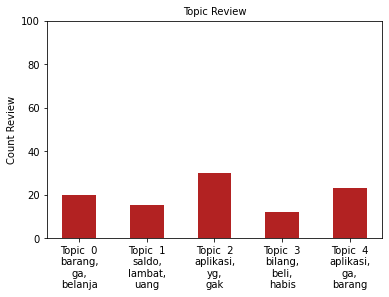

In [ ]:
fig, ax1 = plt.subplots()

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', 
        data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x,pos: 'Topic  ' + str(x)+'\n'+ df_top3words.loc[df_top3words.topic_id==x,'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Topic Review', fontdict=dict(size=10))
ax1.set_ylabel('Count Review')
ax1.set_ylim(0,100)

plt.show()